# Проект ТелеДом

**Описание проекта**

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Ваша задача — обучить на этих данных модель для прогноза оттока клиентов.

**Описание услуг**

Оператор предоставляет два основных типа услуг: 
- Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.
- Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:
    
- Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
- Выделенная линия технической поддержки (TechSupport);
- Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
- Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).
    
Клиенты могут платить за услуги каждый месяц или заключить договор на 1–2 года. Возможно оплатить счёт разными способами, а также получить электронный чек.

**Описание данных**

Данные состоят из нескольких файлов, полученных из разных источников:

- contract_new.csv — информация о договоре;
- personal_new.csv — персональные данные клиента;
- internet_new.csv — информация об интернет-услугах;
- phone_new.csv — информация об услугах телефонии.

Файл contract_new.csv

- customerID — идентификатор абонента;
- BeginDate — дата начала действия договора;
- EndDate — дата окончания действия договора;
- Type — тип оплаты: раз в год-два или ежемесячно;
- PaperlessBilling — электронный расчётный лист;
- PaymentMethod — тип платежа;
- MonthlyCharges — расходы за месяц;
- TotalCharges — общие расходы абонента.

Файл personal_new.csv

- customerID — идентификатор пользователя;
- gender — пол;
- SeniorCitizen — является ли абонент пенсионером;
- Partner — есть ли у абонента супруг или супруга;
- Dependents — есть ли у абонента дети.

Файл internet_new.csv

- customerID — идентификатор пользователя;
- InternetService — тип подключения;
- OnlineSecurity — блокировка опасных сайтов;
- OnlineBackup — облачное хранилище файлов для резервного копирования данных;
- DeviceProtection — антивирус;
- TechSupport — выделенная линия технической поддержки;
- StreamingTV — стриминговое телевидение;
- StreamingMovies — каталог фильмов.

Файл phone_new.csv

- customerID — идентификатор пользователя;
- MultipleLines — подключение телефона к нескольким линиям одновременно.

Во всех файлах столбец customerID содержит код клиента. Информация о договорах актуальна на 1 февраля 2020 года.

## Загрузка данных

In [1]:
import numpy as np
import pandas as pd
import re
import time
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.random import RandomState
from sklearn.metrics import f1_score, roc_curve, roc_auc_score, f1_score, auc
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from catboost import CatBoostClassifier, Pool
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

Загрузим наборы данных и рассмотрим их.

In [2]:
contract = pd.read_csv('/datasets/contract_new.csv')
personal = pd.read_csv('/datasets/personal_new.csv')
internet = pd.read_csv('/datasets/internet_new.csv')
phone = pd.read_csv('/datasets/phone_new.csv')

In [3]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [4]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


Пропусков нет. Неправильный тип данных у столбцов "BeginDate", "EndDate" (должен быть datetime) и "TotalCharges" (должен быть float)

In [5]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


В графе "SeniorCitizen" должно быть yes/no вместо 1/0.

In [6]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


Пропусков нет.

In [7]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [8]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


Пропусков нет. Тип данных определен верно.

In [9]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [10]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


Пропусков нет. Тип данных определен верно.

**Рассмотрели все наборы данных**

## Предобработка данных

Для удобства объединим все данные в один датафрейм

In [11]:
full_df = contract.set_index('customerID').join(phone.set_index('customerID'))
full_df = full_df.join(personal.set_index('customerID'))
full_df = full_df.join(internet.set_index('customerID'))

In [12]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   object 
 7   MultipleLines     6361 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null 

Пропуски для колонок из "internet" и "phone", означающие, что такие услуги пользователям не оказывались, заменим на "No".

Заменяем на "No", тк в датасете используются обозначения "Yes"/"No", это легко увидеть, если вывести все уникальные значения типа object

In [13]:
for column in full_df.columns:
    if (full_df[column].dtype == 'object') and (column != 'BeginDate') and (column != 'EndDate'):
        print(f'\n{column} - ', full_df[column].unique())


Type -  ['Month-to-month' 'One year' 'Two year']

PaperlessBilling -  ['Yes' 'No']

PaymentMethod -  ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']

TotalCharges -  ['31.04' '2071.84' '226.17' ... '325.6' '520.8' '7251.82']

MultipleLines -  [nan 'No' 'Yes']

gender -  ['Female' 'Male']

Partner -  ['Yes' 'No']

Dependents -  ['No' 'Yes']

InternetService -  ['DSL' 'Fiber optic' nan]

OnlineSecurity -  ['No' 'Yes' nan]

OnlineBackup -  ['Yes' 'No' nan]

DeviceProtection -  ['No' 'Yes' nan]

TechSupport -  ['No' 'Yes' nan]

StreamingTV -  ['No' 'Yes' nan]

StreamingMovies -  ['No' 'Yes' nan]


In [14]:
full_df.fillna('No', inplace=True)

In [15]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   7043 non-null   object 
 13  OnlineSecurity    7043 non-null   object 
 14  OnlineBackup      7043 non-null   object 
 15  DeviceProtection  7043 non-null   object 
 16  TechSupport       7043 non-null 

Пропусков больше нет

Исправим названия столбцов на "snake_case"

In [16]:
new_columns = ['begin_date', 'end_date', 'type', 'paperless_billing', 'payment_method', 'monthly_charges',
               'total_charges', 'multiple_lines', 'gender', 'senior_citizen', 'partner', 'dependents',
               'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support',
               'streaming_tv', 'streaming_movies']

In [17]:
full_df.columns = new_columns

In [18]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   begin_date         7043 non-null   object 
 1   end_date           7043 non-null   object 
 2   type               7043 non-null   object 
 3   paperless_billing  7043 non-null   object 
 4   payment_method     7043 non-null   object 
 5   monthly_charges    7043 non-null   float64
 6   total_charges      7043 non-null   object 
 7   multiple_lines     7043 non-null   object 
 8   gender             7043 non-null   object 
 9   senior_citizen     7043 non-null   int64  
 10  partner            7043 non-null   object 
 11  dependents         7043 non-null   object 
 12  internet_service   7043 non-null   object 
 13  online_security    7043 non-null   object 
 14  online_backup      7043 non-null   object 
 15  device_protection  7043 non-null   object 
 16  tech_support  

Исправим неверные типы данных.

In [19]:
full_df['begin_date'] = pd.to_datetime(full_df['begin_date'])

In [20]:
full_df['end_date'].unique()

array(['No', '2017-05-01', '2016-03-01', '2018-09-01', '2018-11-01',
       '2018-12-01', '2019-08-01', '2018-07-01', '2017-09-01',
       '2015-09-01', '2016-07-01', '2016-06-01', '2018-03-01',
       '2019-02-01', '2018-06-01', '2019-06-01', '2020-01-01',
       '2019-11-01', '2016-09-01', '2015-06-01', '2016-12-01',
       '2019-05-01', '2019-04-01', '2017-06-01', '2017-08-01',
       '2018-04-01', '2018-08-01', '2018-02-01', '2019-07-01',
       '2015-12-01', '2014-06-01', '2018-10-01', '2019-01-01',
       '2017-07-01', '2017-12-01', '2018-05-01', '2015-11-01',
       '2019-10-01', '2019-03-01', '2016-02-01', '2016-10-01',
       '2018-01-01', '2017-11-01', '2015-10-01', '2019-12-01',
       '2015-07-01', '2017-04-01', '2015-02-01', '2017-03-01',
       '2016-05-01', '2016-11-01', '2015-08-01', '2019-09-01',
       '2017-10-01', '2017-02-01', '2016-08-01', '2016-04-01',
       '2015-05-01', '2014-09-01', '2014-10-01', '2017-01-01',
       '2015-03-01', '2015-01-01', '2016-01-01', 

Значение "No" в колонке end_date заменим датой окочания датасета "2020-02-01", так как, если дата отсутсвует, значит клиент досрочно не прервал договор и он действовует до последней даты датасета, так мы сможем посчитать длительность контракта на момент выгрузки датасета для всех пользователей.

In [21]:
full_df['end_date'] = full_df['end_date'].replace('No', '2020-02-01')
full_df['end_date'] = pd.to_datetime(full_df['end_date'])

In [22]:
full_df['end_date'].dtype

dtype('<M8[ns]')

In [23]:
full_df['total_charges'] = pd.to_numeric(full_df['total_charges'], errors='coerce')

In [24]:
full_df['total_charges'].isnull().sum()

11

In [25]:
full_df[full_df['total_charges'].isna()]

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,multiple_lines,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
customerID,,,,,,,,,,,,,,,,,,,
4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN,No,Female,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No
3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN,No,Male,0,No,Yes,No,No,No,No,No,No,No
5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN,No,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes
4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,NaN,Yes,Male,0,Yes,Yes,No,No,No,No,No,No,No
1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,NaN,No,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No
7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,NaN,No,Male,0,Yes,Yes,No,No,No,No,No,No,No
3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,NaN,Yes,Male,0,Yes,Yes,No,No,No,No,No,No,No
2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,NaN,No,Female,0,Yes,Yes,No,No,No,No,No,No,No
2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,NaN,No,Male,0,Yes,Yes,No,No,No,No,No,No,No


Можно заметить, что люди с пропусками в общих затратах зарегистрировались недавно, поэтому в поле общие оставим месячные затраты.

In [26]:
full_df.loc[full_df['total_charges'].isna(), 'total_charges'] = full_df[full_df['total_charges'].isna()]['monthly_charges']

В графе "senior_citizen" заменим значения на типичные yes и no

In [27]:
full_df['senior_citizen'] = full_df['senior_citizen'].replace({0: 'No', 1: 'Yes'})

In [28]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7043 non-null   datetime64[ns]
 1   end_date           7043 non-null   datetime64[ns]
 2   type               7043 non-null   object        
 3   paperless_billing  7043 non-null   object        
 4   payment_method     7043 non-null   object        
 5   monthly_charges    7043 non-null   float64       
 6   total_charges      7043 non-null   float64       
 7   multiple_lines     7043 non-null   object        
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   object        
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  internet_service   7043 non-null   object        
 13  online_security    7043 non-null   object        
 14

Данные в датасете записаны в верхнем регистре -> приведем все к нижнему

In [29]:
for column in full_df.columns:
    if (full_df[column].dtype == 'object'):
        full_df[column] = full_df[column].str.lower()

In [30]:
full_df.head()

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,multiple_lines,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,month-to-month,yes,electronic check,29.85,31.04,no,female,no,yes,no,dsl,no,yes,no,no,no,no
5575-GNVDE,2017-04-01,2020-02-01,one year,no,mailed check,56.95,2071.84,no,male,no,no,no,dsl,yes,no,yes,no,no,no
3668-QPYBK,2019-10-01,2020-02-01,month-to-month,yes,mailed check,53.85,226.17,no,male,no,no,no,dsl,yes,yes,no,no,no,no
7795-CFOCW,2016-05-01,2020-02-01,one year,no,bank transfer (automatic),42.30,1960.60,no,male,no,no,no,dsl,yes,no,yes,yes,no,no
9237-HQITU,2019-09-01,2020-02-01,month-to-month,yes,electronic check,70.70,353.50,no,female,no,no,no,fiber optic,no,no,no,no,no,no


Убедимся, что в других столбцах нет аномалий.

In [31]:
for column in full_df.columns:
    if (full_df[column].dtype == 'object'):
        print(f'\n{column} - ', full_df[column].unique())


type -  ['month-to-month' 'one year' 'two year']

paperless_billing -  ['yes' 'no']

payment_method -  ['electronic check' 'mailed check' 'bank transfer (automatic)'
 'credit card (automatic)']

multiple_lines -  ['no' 'yes']

gender -  ['female' 'male']

senior_citizen -  ['no' 'yes']

partner -  ['yes' 'no']

dependents -  ['no' 'yes']

internet_service -  ['dsl' 'fiber optic' 'no']

online_security -  ['no' 'yes']

online_backup -  ['yes' 'no']

device_protection -  ['no' 'yes']

tech_support -  ['no' 'yes']

streaming_tv -  ['no' 'yes']

streaming_movies -  ['no' 'yes']


Аномалий нет.

In [32]:
full_df.duplicated().sum()

4

Есть дубликаты, но их очень мало, поэтому просто удалим их.

In [33]:
full_df = full_df.drop_duplicates().reset_index(drop=True)
full_df.duplicated().sum()

0

<b> Вывод: пропуски заполнены,типы данных исправлены, аномалий нет, дубликатов нет -> предобработка данных проведена

## Исследовательский анализ данных

Добавим целевой признак в данные. Если дата конца договора равна последней дате в датасете - значит клиент остается, ставим 0. Если дата раньше конца датасета - значит клиент уже ушел, ставим 0

In [34]:
full_df['exit'] = 1
full_df.loc[full_df['end_date'] == '2020-02-01', 'exit'] = 0

Text(0.5, 1.0, 'Баланс классов')

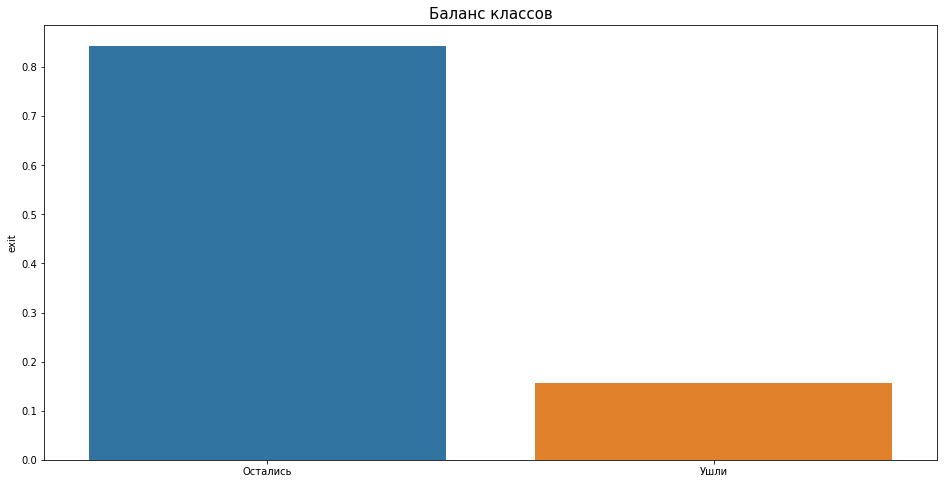

In [35]:
plt.figure(figsize=(16,8))
sns.barplot(x=[0,1], y=full_df['exit'].value_counts() / full_df.shape[0])
plt.xticks([0,1], ['Остались', 'Ушли'])
plt.title('Баланс классов', fontsize=15)

Наблюдается дисбаланс классов.

<b> Составим портрет типичного ушедшего клиента

Построим столбчатые диаграммы показывающие разницу в количестве клиентов определенного типа.

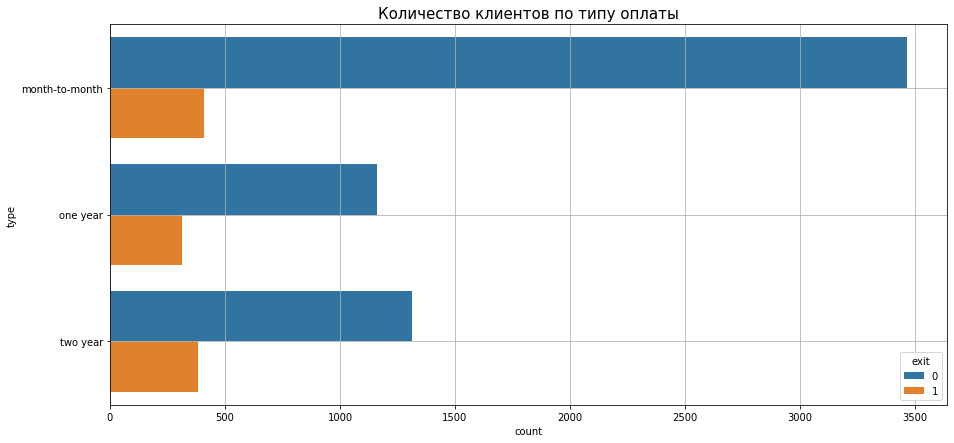

In [36]:
plt.figure(figsize=(15, 7))
sns.countplot(data=full_df, y='type', hue='exit')
plt.title('Количество клиентов по типу оплаты', fontsize=15)
plt.grid()

Text(0.5, 1.0, 'Количество клиентов с электронным чеком')

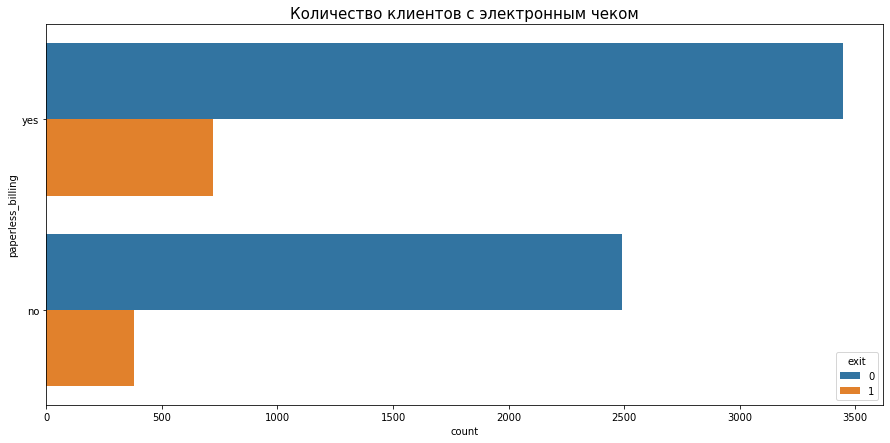

In [37]:
plt.figure(figsize=(15, 7))
sns.countplot(data=full_df, y='paperless_billing', hue='exit')
plt.title('Количество клиентов с электронным чеком', fontsize=15)

Text(0.5, 1.0, 'Количество клиентов по способу оплаты')

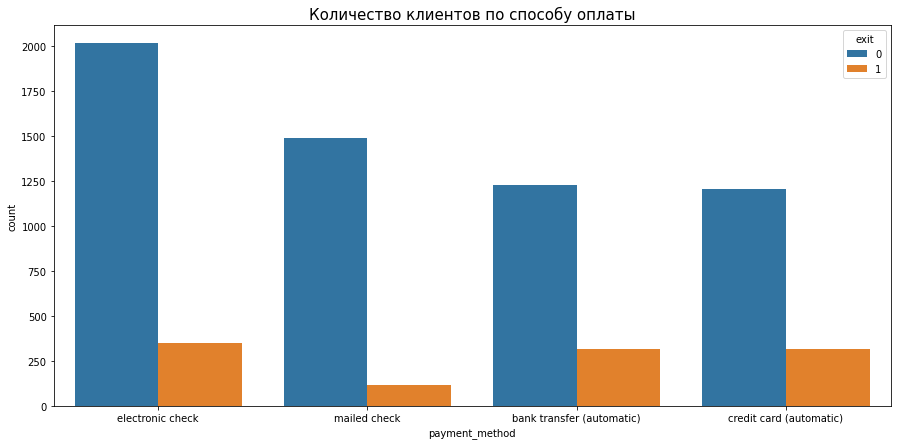

In [38]:
plt.figure(figsize=(15, 7))
sns.countplot(data=full_df, x='payment_method', hue='exit')
plt.title('Количество клиентов по способу оплаты', fontsize=15)

Text(0.5, 1.0, 'Количество клиентов с подключением телефона к нескольким линиям')

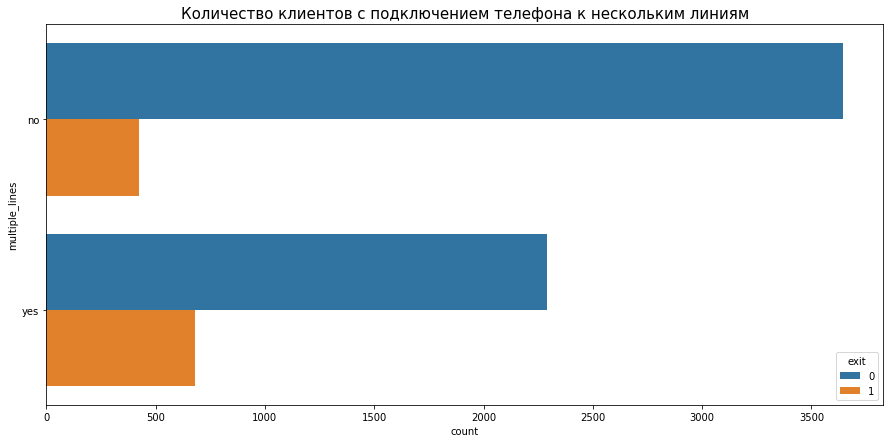

In [39]:
plt.figure(figsize=(15, 7))
sns.countplot(data=full_df, y='multiple_lines', hue='exit')
plt.title('Количество клиентов с подключением телефона к нескольким линиям', fontsize=15)

Text(0.5, 1.0, 'Количество клиентов по полу')

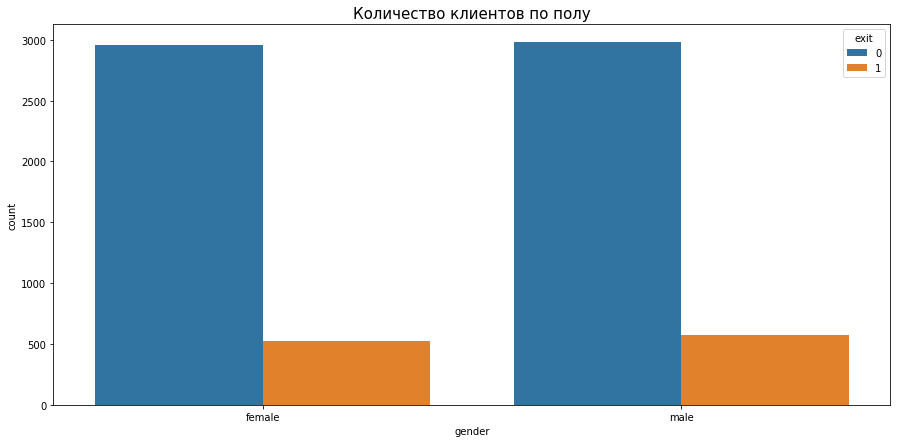

In [40]:
plt.figure(figsize=(15, 7))
sns.countplot(data=full_df, x='gender', hue='exit')
plt.title('Количество клиентов по полу', fontsize=15)

Text(0.5, 1.0, 'Количество пенсионеров')

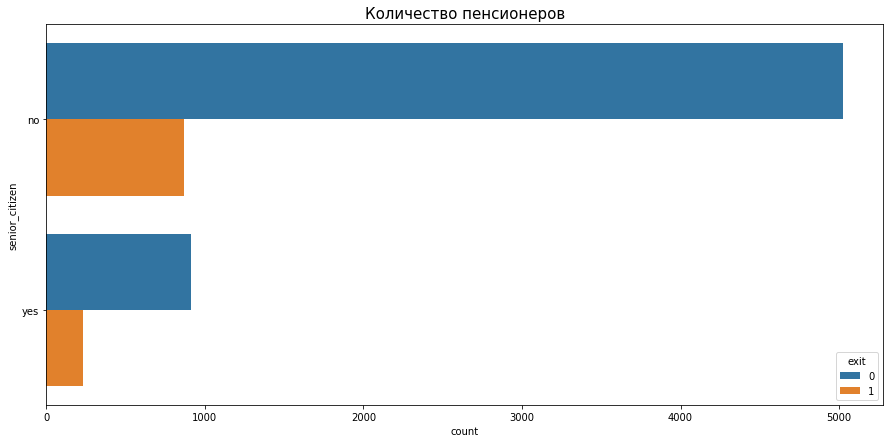

In [41]:
plt.figure(figsize=(15, 7))
sns.countplot(data=full_df, y='senior_citizen', hue='exit')
plt.title('Количество пенсионеров', fontsize=15)

Text(0.5, 1.0, 'Количество женатых клиентов')

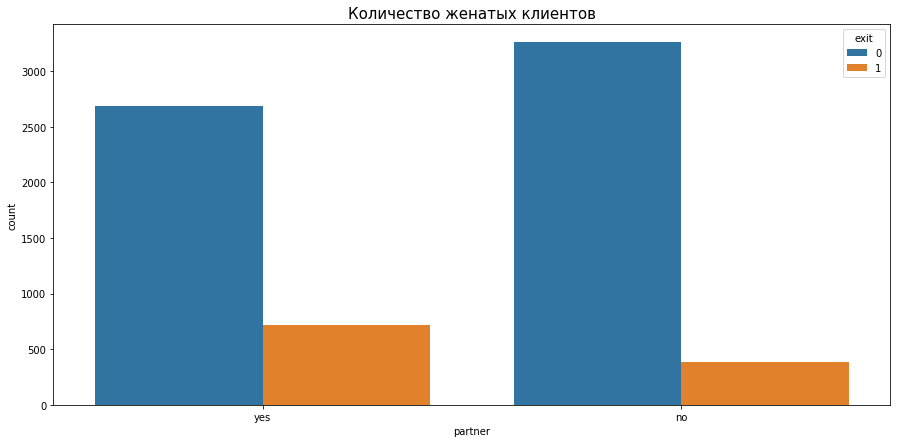

In [42]:
plt.figure(figsize=(15, 7))
sns.countplot(data=full_df, x='partner', hue='exit')
plt.title('Количество женатых клиентов', fontsize=15)

Text(0.5, 1.0, 'Количество клиентов с детьми')

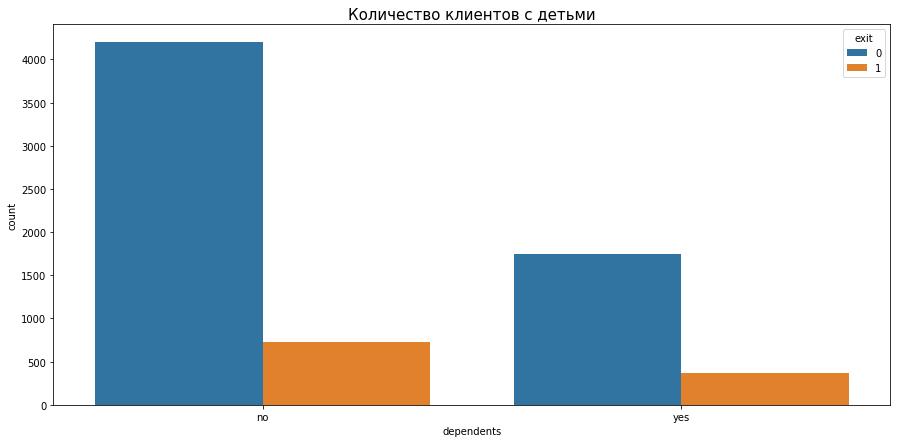

In [43]:
plt.figure(figsize=(15, 7))
sns.countplot(data=full_df, x='dependents', hue='exit')
plt.title('Количество клиентов с детьми', fontsize=15)

Text(0.5, 1.0, 'Тип подключения к интернету')

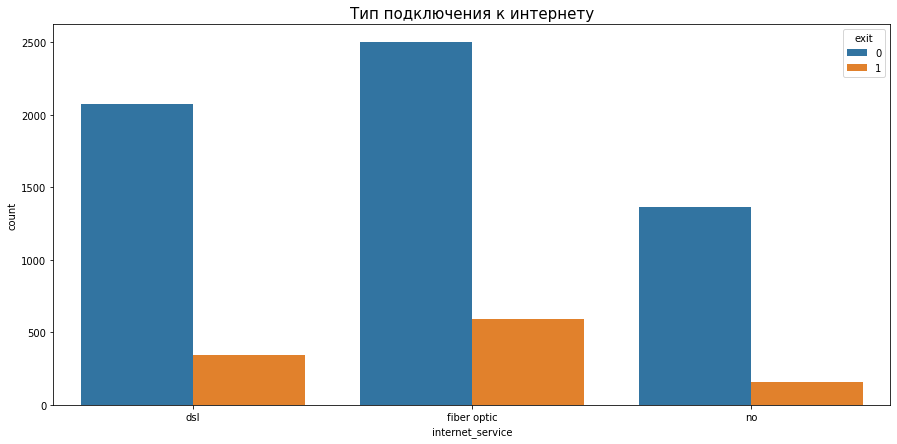

In [44]:
plt.figure(figsize=(15, 7))
sns.countplot(data=full_df, x='internet_service', hue='exit')
plt.title('Тип подключения к интернету', fontsize=15)

<b> Вывод: Типичный портрет ушедшего клиента
    
    - платит ежемесячно
    - получает электронный расчётный лист
    - имеет подключение к нескольким электронным линиям
    - женаты
    - без детей
    - подключены к интернету с помощью оптоволокна

## Подготовка данных

Используем 1 и 0 для практичности обучения моделей.

In [45]:
for column in ['paperless_billing',
               'multiple_lines',
               'senior_citizen',
               'dependents',
               'online_security',
               'online_backup',
               'tech_support',
               'streaming_tv',
               'streaming_movies',
               'partner',
               'device_protection']:
    full_df[column].replace('yes', 1, inplace=True)
    full_df[column].replace('no', 0, inplace=True)
full_df['gender'] = full_df['gender'].replace({'male': 1, 'female': 0})

In [46]:
full_df['gender'].unique()

array([0, 1])

Для обучения моделей не можем использовать дату начала и конца договора, но можем использовать продолжительность.

In [47]:
full_df['duration'] = (full_df['end_date'] - full_df['begin_date']).dt.days

Даты больше не понадобятся нам, удалим их.

In [48]:
full_df.drop(['begin_date', 'end_date'], axis=1, inplace=True)

ID клиента можно удалить, тк не несет в себе никакой информации.

In [49]:
full_df.reset_index(inplace=True)
full_df.drop(['index'], axis=1, inplace=True)

Посмотрим на корреляцию между признаками

<AxesSubplot:title={'center':'КОРРЕЛЯЦИЯ ПРИЗНАКОВ'}>

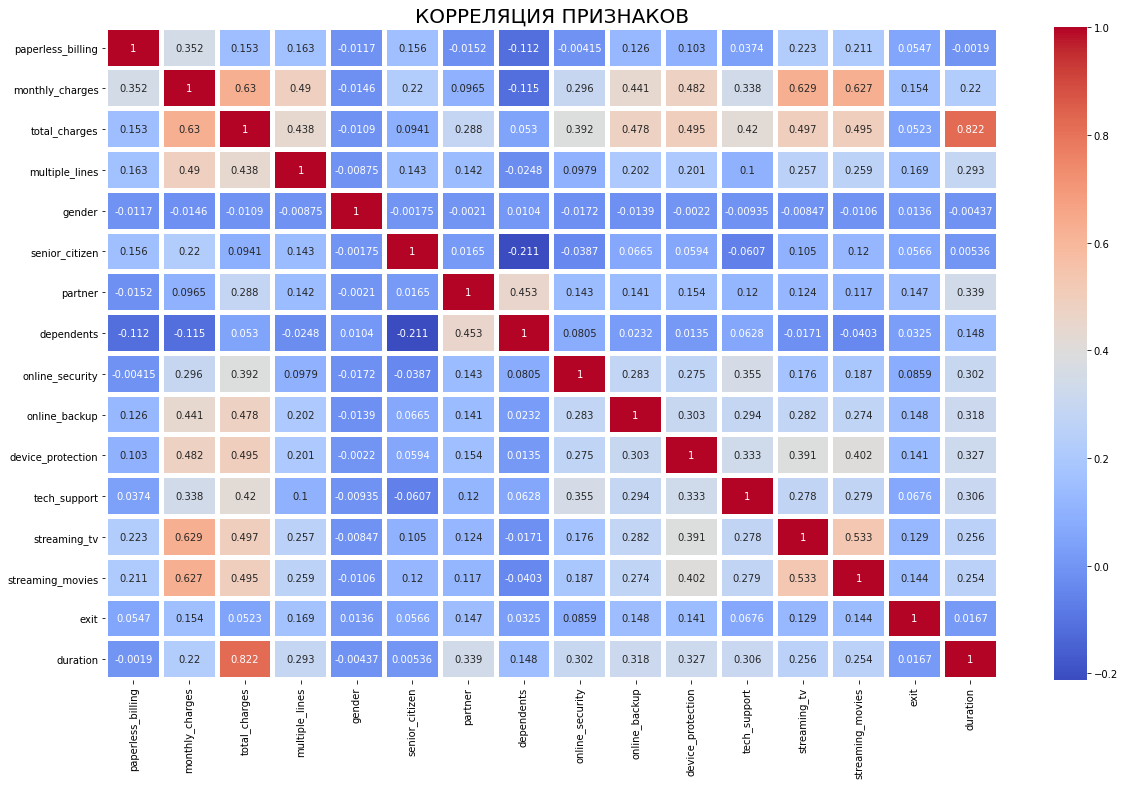

In [50]:
cor = full_df.corr()
fig, ax = plt.subplots(figsize=(20,12))
plt.title('КОРРЕЛЯЦИЯ ПРИЗНАКОВ', fontsize=20)
sns.heatmap(cor, annot=True, cmap="coolwarm",  fmt='.3g', linewidth=4)

Наибольшая корреляция между длительностью контракта и общей суммы оплаты, total_charges уберем.

In [51]:
full_df.drop(['total_charges'], axis=1, inplace=True)

In [52]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7039 entries, 0 to 7038
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7039 non-null   object 
 1   paperless_billing  7039 non-null   int64  
 2   payment_method     7039 non-null   object 
 3   monthly_charges    7039 non-null   float64
 4   multiple_lines     7039 non-null   int64  
 5   gender             7039 non-null   int64  
 6   senior_citizen     7039 non-null   int64  
 7   partner            7039 non-null   int64  
 8   dependents         7039 non-null   int64  
 9   internet_service   7039 non-null   object 
 10  online_security    7039 non-null   int64  
 11  online_backup      7039 non-null   int64  
 12  device_protection  7039 non-null   int64  
 13  tech_support       7039 non-null   int64  
 14  streaming_tv       7039 non-null   int64  
 15  streaming_movies   7039 non-null   int64  
 16  exit               7039 

Сформируем выборки для обучния моделей.

In [53]:
features = full_df.drop(['exit'], axis=1)
target = full_df['exit']

In [54]:
features.head()

,type,paperless_billing,payment_method,monthly_charges,multiple_lines,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,duration
0,month-to-month,1,electronic check,29.85,0,0,0,1,0,dsl,0,1,0,0,0,0,31
1,one year,0,mailed check,56.95,0,1,0,0,0,dsl,1,0,1,0,0,0,1036
2,month-to-month,1,mailed check,53.85,0,1,0,0,0,dsl,1,1,0,0,0,0,123
3,one year,0,bank transfer (automatic),42.30,0,1,0,0,0,dsl,1,0,1,1,0,0,1371
4,month-to-month,1,electronic check,70.70,0,0,0,0,0,fiber optic,0,0,0,0,0,0,153


In [55]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=251223)

In [56]:
print(features_train.shape, features_test.shape)

(5279, 17) (1760, 17)


Закодируем строковые признаки.

In [57]:
features_train = pd.get_dummies(features_train, columns = [ 'payment_method', 'type', 'internet_service'], drop_first = True)
features_test = pd.get_dummies(features_test, columns = [ 'payment_method', 'type', 'internet_service'], drop_first = True)

In [58]:
features_train.columns

Index(['paperless_billing', 'monthly_charges', 'multiple_lines', 'gender',
       'senior_citizen', 'partner', 'dependents', 'online_security',
       'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies', 'duration',
       'payment_method_credit card (automatic)',
       'payment_method_electronic check', 'payment_method_mailed check',
       'type_one year', 'type_two year', 'internet_service_fiber optic',
       'internet_service_no'],
      dtype='object')

In [59]:
features_test.columns

Index(['paperless_billing', 'monthly_charges', 'multiple_lines', 'gender',
       'senior_citizen', 'partner', 'dependents', 'online_security',
       'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies', 'duration',
       'payment_method_credit card (automatic)',
       'payment_method_electronic check', 'payment_method_mailed check',
       'type_one year', 'type_two year', 'internet_service_fiber optic',
       'internet_service_no'],
      dtype='object')

In [60]:
features_train.columns == features_test.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

После кодирования список признаков в тренировочной и тестовой выборках совпадает

Удалим ненужные переменные и приступим к обучению моделей.

In [61]:
del features, target, full_df, contract, personal, internet, phone

**Вывод: лишние признаки удалены, данные подготовлены к обучению моделей**

## Обучение моделей машинного обучения

In [62]:
state = RandomState(251223)

**LogisticRegression**

Стандартизируем числовые данные

In [63]:
selected_columns = ['monthly_charges', 'duration']
features_train_selected = features_train[selected_columns]
features_test_selected = features_test[selected_columns]

scaler = StandardScaler()
features_train_selected_scaled = scaler.fit_transform(features_train_selected)
features_test_selected_scaled = scaler.transform(features_test_selected)

features_train_processed = np.concatenate((features_train_selected_scaled, features_train.drop(selected_columns, axis=1)), axis=1)
features_test_processed = np.concatenate((features_test_selected_scaled, features_test.drop(selected_columns, axis=1)), axis=1)

In [64]:
%%time
start_time = time.time()
model_lr_for_search = LogisticRegression(class_weight='balanced', solver='liblinear', max_iter=1000)
params = dict(C=np.arange(1, 20, 1))
search_for_lr = RandomizedSearchCV(model_lr_for_search, 
                                   params,
                                   scoring='roc_auc',
                                   random_state=state)
search_for_lr.fit(features_train_processed, target_train)
end_time = time.time()
search_time = (end_time - start_time) / 60
print(search_for_lr.best_params_)
print('ROC_AUC:', search_for_lr.best_score_)
print('Time:', search_time)

{'C': 13}
ROC_AUC: 0.7542287047526568
Time: 0.10195957024892172
CPU times: user 3.11 s, sys: 3.01 s, total: 6.12 s
Wall time: 6.12 s


**RandomForestClassifier**

In [65]:
%%time
start_time = time.time()
model_rf_for_search = RandomForestClassifier(class_weight='balanced')

params = dict(n_estimators=np.arange(100, 1000, 100),
              max_depth=np.arange(5,11,1),
              n_jobs=[1,-1])

search_for_rf = RandomizedSearchCV(model_rf_for_search, 
                                   params,
                                   scoring='roc_auc',
                                   random_state=state)
search_for_rf.fit(features_train, target_train)
end_time = time.time()
search_time = (end_time - start_time) / 60
print(search_for_rf.best_params_)
print('ROC_AUC:', search_for_rf.best_score_)
print('Time:', search_time)

{'n_jobs': -1, 'n_estimators': 800, 'max_depth': 7}
ROC_AUC: 0.8179458248881902
Time: 1.5874083558718364
CPU times: user 1min 34s, sys: 706 ms, total: 1min 35s
Wall time: 1min 35s


**CatBoostClassifier**

In [66]:
%%time
start_time = time.time()
train_pool = Pool(features_train, target_train)
cat_for_search = CatBoostClassifier(loss_function='Logloss',
                                    eval_metric='AUC:hints=skip_train~false',
                                    auto_class_weights='Balanced',
                                    verbose=False)
params = {"depth": [5,10], 'learning_rate': [0.1, 1, 0.01]}
grid_search_results = cat_for_search.grid_search(params, train_pool, cv=3, verbose=False,  plot=False)
end_time = time.time()
search_time = (end_time - start_time) / 60
print(grid_search_results['params'])
print('Time:', search_time)


bestTest = 0.8983693268
bestIteration = 987


bestTest = 0.877002337
bestIteration = 354


bestTest = 0.8550461839
bestIteration = 999


bestTest = 0.8591506883
bestIteration = 991


bestTest = 0.8122172834
bestIteration = 1


bestTest = 0.8406607794
bestIteration = 141

Training on fold [0/3]

bestTest = 0.9142543436
bestIteration = 952

Training on fold [1/3]

bestTest = 0.9073069498
bestIteration = 980

Training on fold [2/3]

bestTest = 0.8942724983
bestIteration = 885

{'depth': 5, 'learning_rate': 0.1}
Time: 1.31412087281545
CPU times: user 1min 15s, sys: 1.14 s, total: 1min 16s
Wall time: 1min 18s


In [67]:
models = ['LogisticRegression', 'RandomForestClassifier', 'CatBoostClassifier']
auc1 = [search_for_lr.best_score_, search_for_rf.best_score_, 0.914254]

result = pd.DataFrame({
    'Модель': models, 
    'AUK-ROC': auc1
}) 
result

,Модель,AUK-ROC
0,LogisticRegression,0.754229
1,RandomForestClassifier,0.817946
2,CatBoostClassifier,0.914254


<b> Вывод: Обучены 3 модели и лучшей моделью по итогу кросс-валидации оказалась CatBoostClassifier с показателем AUK-ROC=0.914254

## Тестирование лучшей модели

Обучим лучшую модель и проверим ее на тестовой выборке

In [68]:
best_params = grid_search_results['params']
best_model = CatBoostClassifier(loss_function='Logloss',
                              eval_metric='AUC:hints=skip_train~false',
                              auto_class_weights='Balanced',
                              verbose=False,
                              **best_params)
best_model.fit(features_train, target_train)
probabilities = best_model.predict_proba(features_test)[:, 1]
auc_roc = roc_auc_score(target_test, probabilities)
print(auc_roc)

0.9341488396742731


По результатам тестирования модель выдала показатель лучше. чем на кросс-валидации!

Построим ROC-кривую

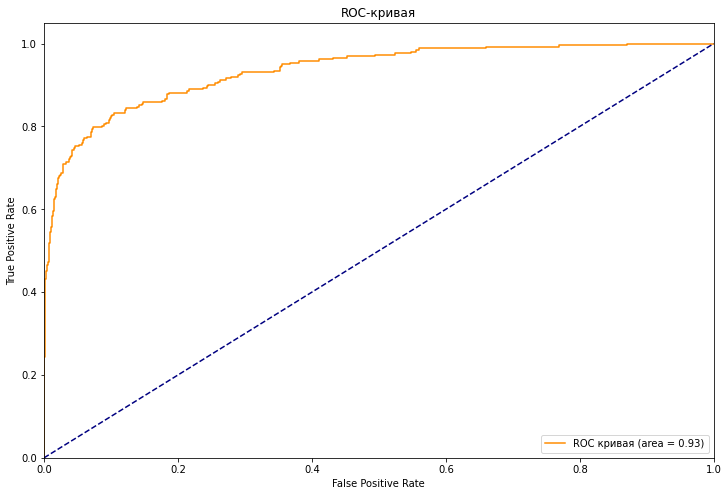

In [69]:
fpr, tpr, tresholds = roc_curve(target_test, probabilities)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=[12, 8])
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.show()

Посмотрим на важность признаков

In [70]:
features_for_cat = best_model.get_feature_importance(train_pool, prettified = True)

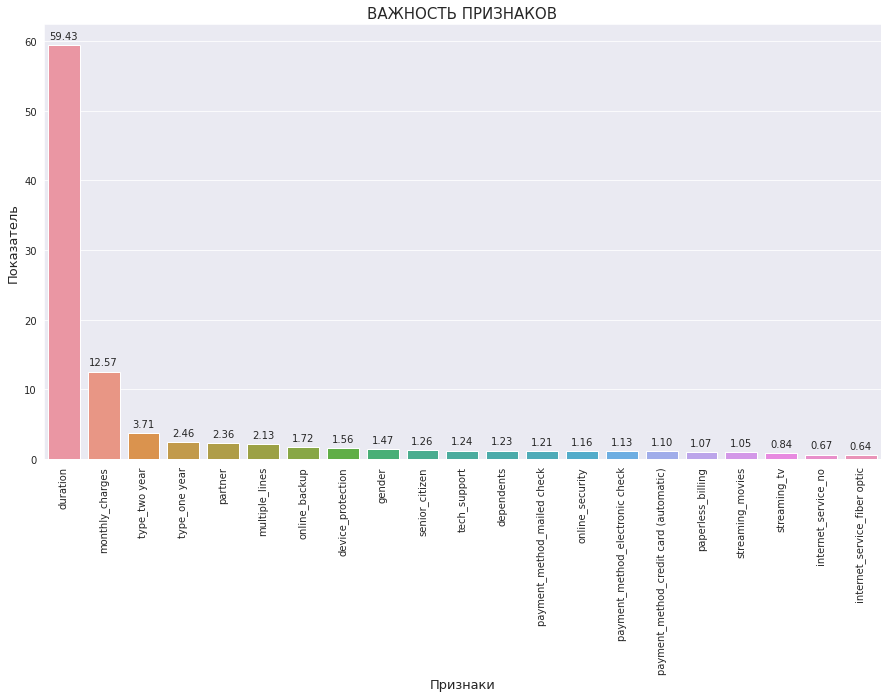

In [71]:
plt.figure(figsize=[15, 8])
sns.set_style('darkgrid')
plt.title('ВАЖНОСТЬ ПРИЗНАКОВ', fontsize=15)
splot = sns.barplot(x='Feature Id', y='Importances', data=features_for_cat.reset_index())
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.tick_params(axis='both', which='major', labelsize=10)
plt.ylabel('Показатель', fontsize=13)
plt.xlabel('Признаки', fontsize=13)
plt.xticks(rotation=90);

<b> Самыми важными признаками влияющими на уход клиента оказались:
1. Длительность договора
2. Месячные траты
3. Тип платежа "раз в два года"
4. Наличия мужа/жены
5. Тип платежа "раз в год"
    
    Что касается продуктов компании, особое внимание стоит обратить на подключение телефона к нескольким линиям и подключение к облачному хранилищу, эти услуги помогают удержать клиента.

<b> Вывод: лучшая модель CatBoostClassifier показала метрику выше, чем на тестовой выборке - AUC-ROC = 0.934148

## Общий вывод и рекомендации заказчику

<b> В этом проекте я работал с данными о клиентах компании «ТелеДом» и строил модель, которая предсказывает разорвет ли клиент контракт или нет.

    Проект выполнялся поэтапно:
1. На первом этапе я изучил данные
2. На втором обработал их (заполнил пропуски, исправил типы данных)
3. На третем привел их в пригодный для обучения моделей вид (убрал лишние признаки, разделил на выборки)
4. На четвертом обучил три разные модели и подабрал лучшие параметры
5. На финальном этапе я протестировал лучшую модель
    
    Итог: лучшая модель - CatBoostClassifier и именно ее я рекомендую использовать заказчику для предсказаний об уходе клиентов
    
    AUC-ROC на тестовой выборке = 0.93856

<b> Рекоммендации заказчику:
    
    1. использование модели CatBoostClassifier для предсказания об уходе клиентов
    2. обратить внимание на такие услуги как подключение телефона к нескольким линиям и подключение к облачному хранилищу, ведь именно они играют ключевую роль в удержании клиента
    3. Типичный портрет ушедшего клиента:
- платит ежемесячно
- получает электронный расчётный лист
- имеет подключение к нескольким электронным линиям
- женаты
- без детей
- подключены к интернету с помощью оптоволокна 
    
    Возможно таким людям стоит чаще отправлять промокоды и делать скидки